#Rational Approximation of the Hyperbolic Tangent Function

The hyperbolic tangent function is useful whenever we need some kind of smooth saturating behavior, as - for example - in the simulation of analog circuits and filters. It is defined as:
$$
y = \tanh(x) =\frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$
Let's have a look at it:

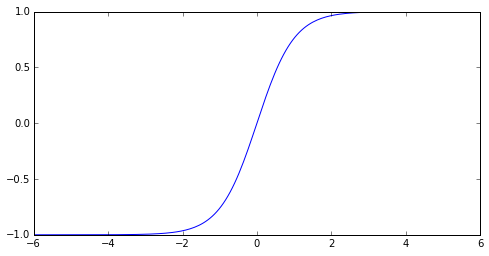

In [1]:
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
x = linspace(-6, +6, 201)
y = tanh(x)
plot(x, y)
gcf().set_size_inches(8, 4)

In an actual simulation of a circuit, it would be very expensive to evaluate this function whenever it is needed, so it is desirable to have a computationally cheap approximation. Here, we will consider a rational approximation of the form:
$$
r(x) = \frac{\sum_{n=0}^N a_n x^n}{\sum_{n=0}^M b_n x^n}
$$
where $N, M$ are the orders of the numerator and denomiator polynomial respectively. The asymptotic behavior of $\tanh$ is that is approaches $\pm 1$ as $x$ approaches $\pm \infty$. Our approximating rational function, on the other hand, asymptotically approaches a function $r_a(x) = \frac{a_N x^N}{b_M x^M}$ - that is: in the limit of large $x$, the highest order terms in the numerator and denominator will dominate. In approximating saturating behavior, it seems to be desirable that our approximant remains bounded which will be the case for $N \leq M$. Moreover, we note that the tanh function features odd symmetry - we can build such an odd symmetry into our approximant by choosing an odd polynomial for the numerator and an even polynomial for the denominator (or vice versa). Even polynomials have nonzero coefficients only for even powers of $x$, odd polynomials likewise only for odd powers. This suggests that we choose an even polynomial for the numerator and an odd polynomial for the denominator (or the other way around). Because we want to ensure that $N \leq M$, we choose $M = N+1$ - the denominator is one order higher than the numerator. This leads to an asymptotic behavior of $r_a(x) = \frac{a_N}{b_M x}$, which means, instead of saturating to a fixed value, our function will fall back to $0$ proportionally to $1/x$ for large $x$. To find values for the coefficients of our polynomials, we consider the series expansions of $\sinh(x)$ and $\cosh(x)$ around $x=0$ which are given by:
$$
\sinh(x) = x + \frac{x^3}{3!} + \frac{x^5}{5!} + \frac{x^7}{7!} + \ldots \\
\cosh(x) = 1 + \frac{x^2}{2!} + \frac{x^4}{4!} + \frac{x^5}{5!} + \ldots
$$
We may choose our polynomial cofficients as the coefficients in the truncated series expansion. For example, with $N=3, M=N+1=4$ we would have:
$$
r(x) = \frac{\sum_{n=0}^3 a_n x^n}{\sum_{n=0}^4 b_n x^n} 
     = \frac{a_1 x + a_3    x^3}{b_0 + b_2    x^2 + b_4    x^4}
     = \frac{    x + (1/3!) x^3}{1   + (1/2!) x^2 + (1/4!) x^4}
     = \frac{    x + x^3/6}{1   + x^2/2 + x^4/24}
$$
Let's call the value $M$ the order of our approximation, so in the equation above, the order would be $4$. We now want to write a python function that takes this order $M$ as input parameter and returns the arrays of polynomial coefficients $a, b$. To this end, we first define a function <code>hypcof</code> that returns the the order $M$ expansion either for the hyperbolic sine or cosine depending on whether $M$ is odd or even and then use this function for the numerator with parameter $M-1$ and the denominator with $M$:

In [2]:
from math import factorial

def hypcof(M):    # sinh/cosh series coefficients for order M approximation
    f = zeros(M+1)
    k = M % 2
    for n in range(k, M+1, 2):
        f[n] = 1 / factorial(n)
    return f
    
def tanhcof(M):   # tanh rational series approximation coefficients
    a = hypcof(M-1)
    b = hypcof(M)
    return a, b

Next, we define a function <code>ratval</code> that evaluates the rational function given parameter arrays $a, b$ and an input value $x$.

In [3]:
def polval(a, x):                # evaluate polynomial with coeffs in a at x
    p = 0
    for n in range(0, len(a)):
        p += a[n] * x**n         # this is a silly way to evaluate a polynomial
    return p                     # ...but i don't care in this case

def ratval(a, b, x):             # evaluate rational with coeffs in a, b at x
    return polval(a, x) / polval(b, x)

Note that our <code>ratval</code> function has no check against a division by zero. Divisions by zero may occur in our setting only when the denominator has a zero crossing which is the case for odd $M$. Therefore, we will restrict ourselves to even $M$, so we don't need to handle that case. In order to create plots of approximations of various orders (and compare them to the target function), we write a convenience function that obtains the coefficients and evaluates the function at an array of x-values:

In [4]:
def tanhapprox(x, M):
    a, b = tanhcof(M)
    return ratval(a, b, x)

Now let's plot approximations for orders 2, 4, 6 along with the original tanh function for comparison:

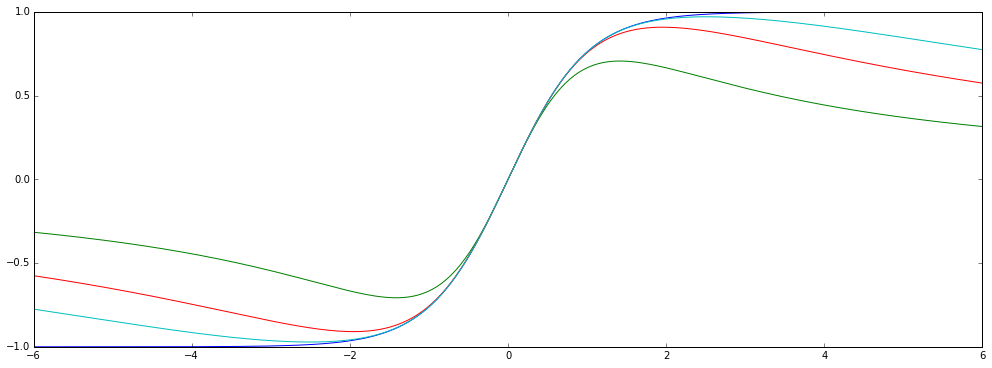

In [5]:
y2 = tanhapprox(x, 2)
y4 = tanhapprox(x, 4)
y6 = tanhapprox(x, 6)
plot(x, y)
plot(x, y2)
plot(x, y4)
plot(x, y6)
gcf().set_size_inches(17, 6)

As it is typical for approximations based on a truncated series expansion, our approximants fit the target function best around the expansion center (which is 0 in this case) and become progressively worse, the further away we go from that expansion point. The higher the order, the better the fit and the larger the range where target function and approximant agree reasonably well. Sometimes, it is more desirable to match the target function in the sense of a least-squares fit in a given range. We can compute such a least-squares fit using the <code>curve_fit</code> function from <code>scipy.optimize</code>. For the curve fitting routine, we need to define a function that takes an input value $x$ and a parameter vector $p$ which must be passed a (variable) number of additional separate arguments. We will do this least squares fit for the $M=4$ case and we define our parameter vector as $p = (a_1, a_3, b_0, b_2, b_4)$. We write some functions to conveniently pack and unpack the parameter vector from our $a, b$ representation and a function to evaluate the approximant in terms of the 5 parameter values (as separate parameters, suitable for the optimizer):

In [6]:
def pack4(a, b):
    return [a[1], a[3], b[0], b[2], b[4]]

def unpack4(p):
    a = zeros(4)
    b = zeros(5)   
    a[1] = p[0]
    a[3] = p[1]
    b[0] = p[2]
    b[2] = p[3]
    b[4] = p[4]
    return a, b

def rat4(x, a1, a3, b0, b2, b4):
    return (a1*x + a3*x**3) / (b0 + b2*x**2 + b4*x**4)

Now, we write a function that computes an optimized parameter set - we give it as parameters the maximum value of $x$, i.e. the range in which we want the fit to be good and the number of datapoints for the optimizer. Because the function is symmetric, we don't need to specifiy a minimum x-value - using zero is adequate. The optimization routine works by iteratively improving a current best guess for the parameter values, so it needs an initial guess. We use the values from the series expansion for that (otherwise it would use an all-ones vector by default).

In [7]:
from scipy.optimize import curve_fit

def tanhcofs4(xmax, nvals):
    x = linspace(0, xmax, nvals)
    y = tanh(x)    
    a, b = tanhcof(4)                 # use series expansion coeffs
    p = pack4(a, b)                   # as initial guess for parameter vector
    p, c = curve_fit(rat4, x, y, p)  # 2nd output is covariance
    return unpack4(p)                 # unpack parameter vector

Finally, we use this function to compute a least-squares 4th order fit to tanh and plot the resulting approximant together with the original tanh function and the 4th order series expansion approximation. We use 200 datapoints for a least squares fit in the range 0...6, and we will plot the functions in the range 0...16

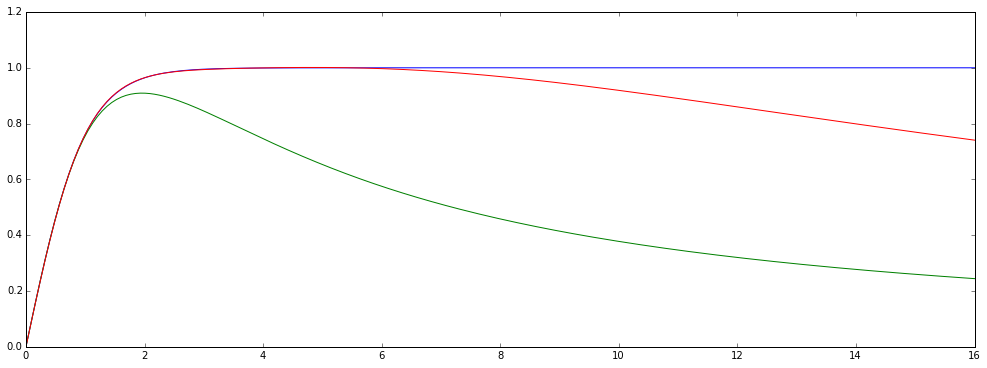

In [8]:
x = linspace(0, 16, 200)
y = tanh(x)
plot(x, y)                      # plot original function
a, b = tanhcof(4)               # compute series expansion coefficients
plot(x, ratval(a, b, x))        # plot truncated series expansion
a, b = tanhcofs4(6, 200)        # fit in the range 0...6 using 200 points
plot(x, ratval(a, b, x))        # plot least squares fit
gcf().set_size_inches(17, 6)

As we can see, our approximant fits the tanh pretty well in the range for which it was optimized, and decays smoothly back to zero thereafter due to the inevitable asymptotic behaviour that was built into the function by construction. Of course, it would be desirable that the approximant would show saturating behavior as well instead of falling back, but looking at the expression for the general asymptotic behavior of rational functions $r_a(x) = \frac{a_N x^N}{b_M x^M}$, it doesn't seem to be possible to consruct a rational function that is saturating to $\pm 1$ as $x \rightarrow \pm \infty$. If $N>M$, it will eventually diverge, if $N<M$, it will eventually fall back to zero and if $N=M$, it will approach a constant value given by $\frac{a_N}{b_M}$ - but this value will either be positive or negative for both sides - not negative for the left side and positive for the right side, as we would wish. So, it seems, the best we can do with this kind of function is accept the falling back to zero. Let's print out the optimized coefficients, so we may copy and paste them into some code, when we actually want to use the approximation:

In [9]:
set_printoptions(precision=16)
print(a)
print(b)

[  0.                  10.4454346895600487   0.                   0.7433152547508219]
[ 10.5011694608434105   0.                   4.1322313175491203   0.
   0.0498609822817115]


Finally, let's write a function into which we hardcode the obtained numbers. It should be obvious, how to translate and possibly further optimize it in the target language of choice.

In [11]:
def tanh4(x):
    x2 = x*x;
    n = 10.4454346895600487*x + 0.7433152547508219*x*x2
    d = 10.5011694608434105 + 4.1322313175491203*x2 + 0.0498609822817115*x2*x2
    return n/d